In [1]:
import sys
import os

# 경로 설정: 스크립트 경로에서 상위 디렉토리로 이동한 후 src 경로 추가
health_data_path = os.path.abspath(os.path.join('..', 'src'))
health_learning_data_path = os.path.abspath(os.path.join(os.getcwd(), "../../HealthModelPipeline/dataflow/src"))
preprocessing_path = os.path.abspath(os.path.join(os.getcwd(), "../../PipelinePrep/src"))

paths = [health_data_path, health_learning_data_path, preprocessing_path]

def add_paths(paths):
    """
    지정된 경로들이 sys.path에 없으면 추가하는 함수.

    Parameters:
    - paths (list): 추가하려는 경로들의 리스트.
    """
    for path in paths:
        if path not in sys.path:
            sys.path.append(path)
            print(f"Path added: {path}")
        else:
            print(f"Path already exists: {path}")

add_paths(paths)

Path added: C:\Users\admin\Techross\HealthPipeline\src
Path added: C:\Users\admin\Techross\HealthModelPipeline\dataflow\src
Path added: C:\Users\admin\Techross\PipelinePrep\src


In [2]:
# basic
import pandas as pd

# time
import schedule
import time

# module.healthchecker
from stat_healthchecker.total_system_health_algorithm import apply_system_health_algorithms_with_total
from models_healthchecker.total_system_health_learning_algorithm import apply_system_health_learning_algorithms_with_total
from prep.load_processing import distribute_by_application

# module.dataline
from stat_dataline.scheduled_data_fetcher import fetch_data_on_schedule
from stat_dataline.logger_confg import logger
from stat_dataline.select_dataset import get_dataframe_from_database

In [3]:
def find_outage_index(data=None, judgment=True):

    if judgment:
        data = get_dataframe_from_database('ecs_dat1', 'ecs_data_new', all=True)

    # 해당 오퍼레이션 인덱스 탐색
    grouped_data = data.groupby(['SHIP_ID','OP_INDEX','SECTION']).count()
    grouped_index = grouped_data.index
    datas = pd.DataFrame(index = grouped_index).reset_index()

    # 탐색값 반환
    return datas[(datas['SHIP_ID']=='T20220324006') & (datas['OP_INDEX']==648) & (datas['SECTION']==0)]

In [4]:
def get_latest_date_on_schedule():

    # last_fetched ~ current date → data extract
    # fetched_data = fetch_data_on_schedule('ecs_dat1', 'ecs_data')

    fetched_data = get_dataframe_from_database('ecs_dat1', 'ecs_data_new', all=True)

    # 해당 추출 데이터 그룹화
    grouped_data = fetched_data.groupby(['SHIP_ID','OP_INDEX','SECTION']).count()

    # 그룹 후 인덱스 추출
    grouped_index = grouped_data.index

    return grouped_index, fetched_data

In [5]:
def schedule_health_assessment():

    grouped_index, fetched_data = get_latest_date_on_schedule()

    for index in grouped_index[50:100]:

        # 해당 오퍼레이션 선박, 인덱스, 섹션 추출
        ship_id =  index[0]
        op_index = index[1]
        section =  index[2]

        # 데이터 처리를 위한 갯수 조건을 만족하는지 판단
        selected_df = fetched_data[(fetched_data['SHIP_ID']==ship_id) & (fetched_data['OP_INDEX']==op_index) & (fetched_data['SECTION']==section)]

        # 해당 오퍼레이션 데이터 길이 추출
        data_len = len(selected_df)

        # 해당 오퍼레이션 시작 시간 추출
        date_time = selected_df.iloc[0]['DATA_TIME']

        print(f'SHIP_ID : {ship_id} / OP_INDEX : {op_index} / SECTION : {section} -  데이터 선택 ({data_len})')

        if (data_len>=160) :

            print(f'SHIP_ID : {ship_id} / OP_INDEX : {op_index} / SECTION : {section} -  조건 통과')

            try:
                sensor, preprocessed = distribute_by_application(ship_id=ship_id, op_index=op_index, section=section)
                if sensor is None and preprocessed is None:
                    print("선박 데이터 프레임이 존재하지 않습니다.")
                    continue

                elif preprocessed is not None:
                    logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY=The results were derived from the model and statistics package | TYPE=all | IS_PROCESSED=True')
                    print("전처리 후 학습 데이터 프레임이 존재합니다.")
                    apply_system_health_algorithms_with_total(sensor, ship_id, op_index, section)
                    apply_system_health_learning_algorithms_with_total(data=preprocessed, ship_id=ship_id, op_index=op_index, section=section)
                else:
                    logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time}  | LOG_ENTRY=After preprocessing, the model data frame does not exist, so only the statistical algorithm proceeds alone | TYPE=stats | IS_PROCESSED=True')
                    print("전처리 후 모델 데이터 프레임이 존재하지 않아 통계 알고리즘 단독 진행합니다.")
                    apply_system_health_algorithms_with_total(data=sensor, ship_id=ship_id, op_index=op_index, section=section)

            except ValueError as e :
                logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
                print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
                continue  # 에러 발생 시 다음 반복으로 넘어감\

            except KeyError as e :
                logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
                print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')

            except TypeError as e :
                logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
                print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
                continue  # 에러 발생 시 다음 반복으로 넘어감

            except IndexError as e :
                print(f'에러 발생: {e}. 다음 반복으로 넘어갑니다.')
                logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY={e} | TYPE=exceptional_handling | IS_PROCESSED=False')
                continue  # 에러 발생 시 다음 반복으로 넘어감
        else:
            logger.info(f'SHIP_ID={ship_id} | OP_INDEX={op_index} | SECTION={section} | START_TIME={date_time} | LOG_ENTRY=The data length is {data_len} and does not satisfy the condition | TYPE=data_length_limit | IS_PROCESSED=False')

SHIP_ID : T121129-05501 / OP_INDEX : 66 / SECTION : 0 -  데이터 선택 (27)
SHIP_ID : T121129-05501 / OP_INDEX : 67 / SECTION : 0 -  데이터 선택 (22)
SHIP_ID : T121129-05501 / OP_INDEX : 68 / SECTION : 0 -  데이터 선택 (6)
SHIP_ID : T121129-05501 / OP_INDEX : 69 / SECTION : 0 -  데이터 선택 (5)
SHIP_ID : T121129-05501 / OP_INDEX : 70 / SECTION : 0 -  데이터 선택 (14)
SHIP_ID : T121129-05501 / OP_INDEX : 71 / SECTION : 0 -  데이터 선택 (25)
SHIP_ID : T121129-05501 / OP_INDEX : 72 / SECTION : 0 -  데이터 선택 (20)
SHIP_ID : T121129-05501 / OP_INDEX : 73 / SECTION : 0 -  데이터 선택 (24)
SHIP_ID : T121129-05501 / OP_INDEX : 74 / SECTION : 0 -  데이터 선택 (37)
SHIP_ID : T121129-05501 / OP_INDEX : 75 / SECTION : 0 -  데이터 선택 (55)
SHIP_ID : T121129-05501 / OP_INDEX : 76 / SECTION : 0 -  데이터 선택 (9)
SHIP_ID : T121129-05501 / OP_INDEX : 77 / SECTION : 0 -  데이터 선택 (9)
SHIP_ID : T121129-05501 / OP_INDEX : 78 / SECTION : 0 -  데이터 선택 (18)
SHIP_ID : T121129-05501 / OP_INDEX : 79 / SECTION : 0 -  데이터 선택 (18)
SHIP_ID : T121129-05501 / OP_INDEX : 8

ModuleNotFoundError: No module named 'xgboost'

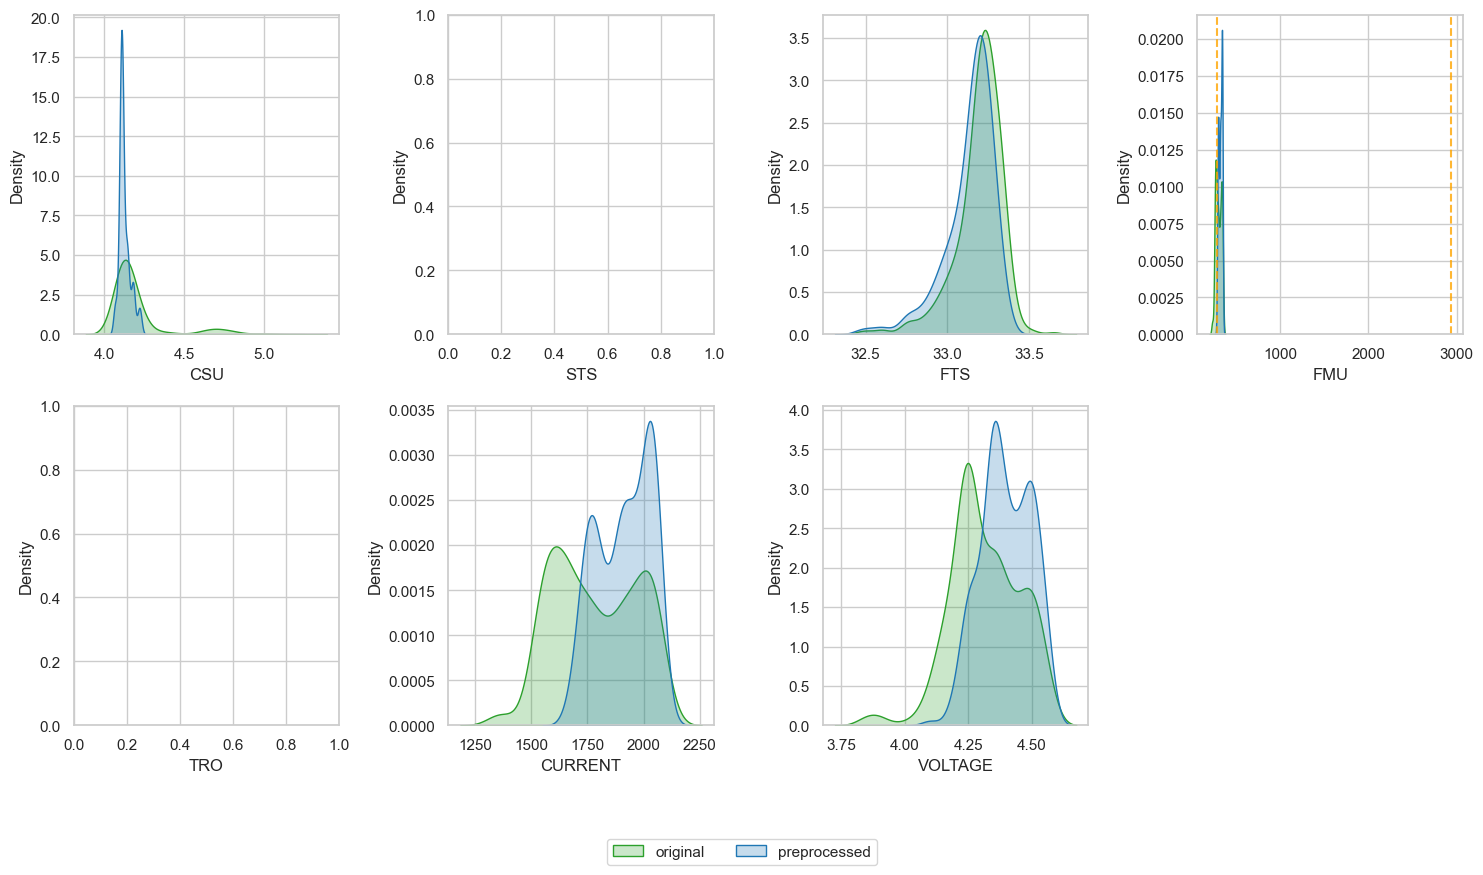

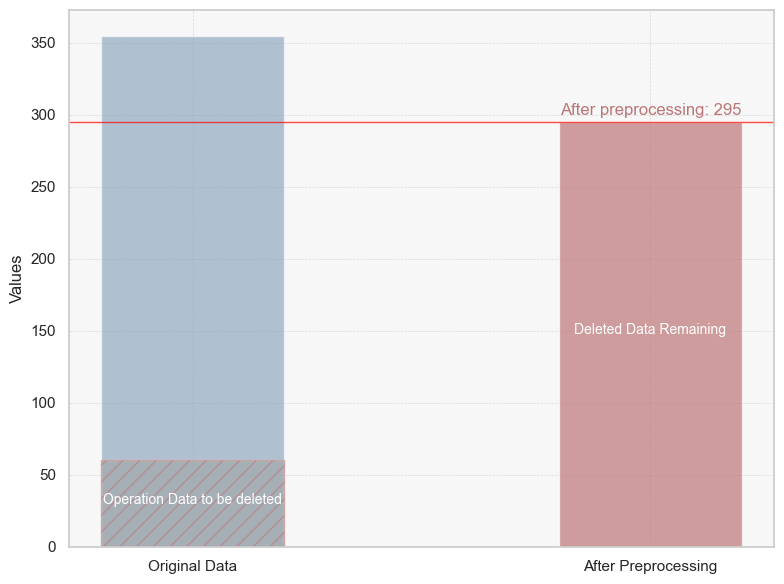

In [6]:
schedule_health_assessment()